### Installing pyspark

In [85]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
from pyspark.sql import SparkSession
import pandas as pd

#### Loading the dataset...

In [87]:
spark = SparkSession.builder.getOrCreate()

data=spark.read.csv("spam_data.csv")


In [88]:
rows=data.count()
cols=len(data.columns)
print(f"The data set contains {rows} rows and {cols} columns.")

The data set contains 5574 rows and 2 columns.


In [89]:
# to know the column names of the data set
data.columns

['_c0', '_c1']

In [90]:
data = data.withColumnRenamed('_c0','class').withColumnRenamed('_c1','text')

In [91]:
data.printSchema()

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)



In [92]:

data.show()

+-----+--------------------+
|class|                text|
+-----+--------------------+
|  ham|Go until jurong p...|
|  ham|Ok lar... Joking ...|
| spam|Free entry in 2 a...|
|  ham|U dun say so earl...|
|  ham|Nah I don't think...|
| spam|FreeMsg Hey there...|
|  ham|Even my brother i...|
|  ham|As per your reque...|
| spam|WINNER!! As a val...|
| spam|Had your mobile 1...|
|  ham|I'm gonna be home...|
| spam|SIX chances to wi...|
| spam|URGENT! You have ...|
|  ham|I've been searchi...|
|  ham|I HAVE A DATE ON ...|
| spam|XXXMobileMovieClu...|
|  ham|Oh k...i'm watchi...|
|  ham|Eh u remember how...|
|  ham|Fine if thatÂ’s t...|
| spam|England v Macedon...|
+-----+--------------------+
only showing top 20 rows



In [93]:
from pyspark.sql.functions import length

In [94]:
data = data.withColumn('length',length(data['text']))
data.show()

+-----+--------------------+------+
|class|                text|length|
+-----+--------------------+------+
|  ham|Go until jurong p...|   111|
|  ham|Ok lar... Joking ...|    29|
| spam|Free entry in 2 a...|   155|
|  ham|U dun say so earl...|    49|
|  ham|Nah I don't think...|    61|
| spam|FreeMsg Hey there...|   148|
|  ham|Even my brother i...|    77|
|  ham|As per your reque...|   160|
| spam|WINNER!! As a val...|   158|
| spam|Had your mobile 1...|   154|
|  ham|I'm gonna be home...|   109|
| spam|SIX chances to wi...|   136|
| spam|URGENT! You have ...|   156|
|  ham|I've been searchi...|   196|
|  ham|I HAVE A DATE ON ...|    35|
| spam|XXXMobileMovieClu...|   149|
|  ham|Oh k...i'm watchi...|    26|
|  ham|Eh u remember how...|    81|
|  ham|Fine if thatÂ’s t...|    58|
| spam|England v Macedon...|   156|
+-----+--------------------+------+
only showing top 20 rows



### Removing null values

In [95]:
from pyspark.sql.functions import col

In [96]:
new_data=data.filter(col("text").isNotNull())


In [97]:
new_data.groupby('class').mean().show()

+-----+------------------+
|class|       avg(length)|
+-----+------------------+
|  ham| 71.07626943005181|
| spam|138.89558232931728|
+-----+------------------+



#### An average difference of 139 and 71 is big enough to use it as a feature in modeling.



In [98]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

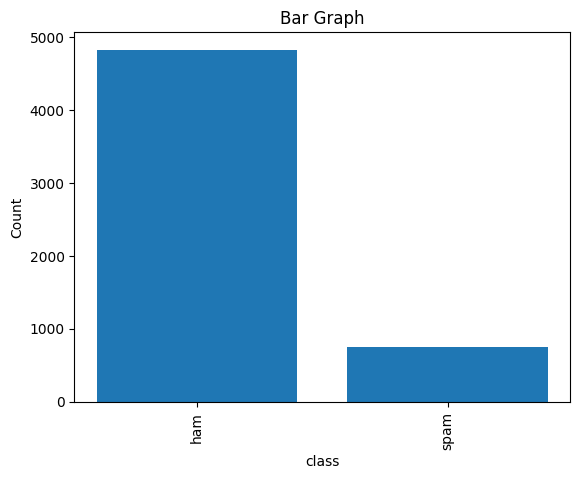

In [99]:
count_df = new_data.groupBy('class').count().orderBy(col('count').desc())
categories = count_df.select('class').rdd.flatMap(lambda x: x).collect()
counts = count_df.select('count').rdd.flatMap(lambda x: x).collect()
plt.bar(categories, counts)
plt.xlabel('class')
plt.ylabel('Count')
plt.title('Bar Graph')
plt.xticks(rotation='vertical')
plt.show()

#### Applying tokenizer

In [100]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover

In [101]:
tokenizer=Tokenizer(inputCol="text",outputCol="Token_words")
data_tokenized=tokenizer.transform(new_data)

In [102]:
data_tokenized.show()

+-----+--------------------+------+--------------------+
|class|                text|length|         Token_words|
+-----+--------------------+------+--------------------+
|  ham|Go until jurong p...|   111|[go, until, juron...|
|  ham|Ok lar... Joking ...|    29|[ok, lar..., joki...|
| spam|Free entry in 2 a...|   155|[free, entry, in,...|
|  ham|U dun say so earl...|    49|[u, dun, say, so,...|
|  ham|Nah I don't think...|    61|[nah, i, don't, t...|
| spam|FreeMsg Hey there...|   148|[freemsg, hey, th...|
|  ham|Even my brother i...|    77|[even, my, brothe...|
|  ham|As per your reque...|   160|[as, per, your, r...|
| spam|WINNER!! As a val...|   158|[winner!!, as, a,...|
| spam|Had your mobile 1...|   154|[had, your, mobil...|
|  ham|I'm gonna be home...|   109|[i'm, gonna, be, ...|
| spam|SIX chances to wi...|   136|[six, chances, to...|
| spam|URGENT! You have ...|   156|[urgent!, you, ha...|
|  ham|I've been searchi...|   196|[i've, been, sear...|
|  ham|I HAVE A DATE ON ...|   

#### Removing stop words like in, on...

In [103]:
stop_remover=StopWordsRemover(inputCol="Token_words",outputCol="after_remov_STOP")
data_filtered=stop_remover.transform(data_tokenized)

In [104]:
data_filtered.show()

+-----+--------------------+------+--------------------+--------------------+
|class|                text|length|         Token_words|    after_remov_STOP|
+-----+--------------------+------+--------------------+--------------------+
|  ham|Go until jurong p...|   111|[go, until, juron...|[go, jurong, poin...|
|  ham|Ok lar... Joking ...|    29|[ok, lar..., joki...|[ok, lar..., joki...|
| spam|Free entry in 2 a...|   155|[free, entry, in,...|[free, entry, 2, ...|
|  ham|U dun say so earl...|    49|[u, dun, say, so,...|[u, dun, say, ear...|
|  ham|Nah I don't think...|    61|[nah, i, don't, t...|[nah, think, goes...|
| spam|FreeMsg Hey there...|   148|[freemsg, hey, th...|[freemsg, hey, da...|
|  ham|Even my brother i...|    77|[even, my, brothe...|[even, brother, l...|
|  ham|As per your reque...|   160|[as, per, your, r...|[per, request, 'm...|
| spam|WINNER!! As a val...|   158|[winner!!, as, a,...|[winner!!, valued...|
| spam|Had your mobile 1...|   154|[had, your, mobil...|[mobile,

### Generating numeric features using Word2Vec, this data is required for finding frequences

In [105]:
from pyspark.ml.feature import Word2Vec

In [106]:
word_vec=Word2Vec(vectorSize=100,inputCol="after_remov_STOP",outputCol="word2vec")
model=word_vec.fit(data_filtered)
final_data=model.transform(data_filtered)

In [107]:
final_data.show(4)

+-----+--------------------+------+--------------------+--------------------+--------------------+
|class|                text|length|         Token_words|    after_remov_STOP|            word2vec|
+-----+--------------------+------+--------------------+--------------------+--------------------+
|  ham|Go until jurong p...|   111|[go, until, juron...|[go, jurong, poin...|[0.00293911184962...|
|  ham|Ok lar... Joking ...|    29|[ok, lar..., joki...|[ok, lar..., joki...|[0.00327084316328...|
| spam|Free entry in 2 a...|   155|[free, entry, in,...|[free, entry, 2, ...|[0.00791389956746...|
|  ham|U dun say so earl...|    49|[u, dun, say, so,...|[u, dun, say, ear...|[0.00499346420272...|
+-----+--------------------+------+--------------------+--------------------+--------------------+
only showing top 4 rows



### Visualizing using wordcloud

In [108]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [110]:
ham_data= data.filter(data["class"] == "ham")
spam_data = data.filter(data["class"] == "spam")

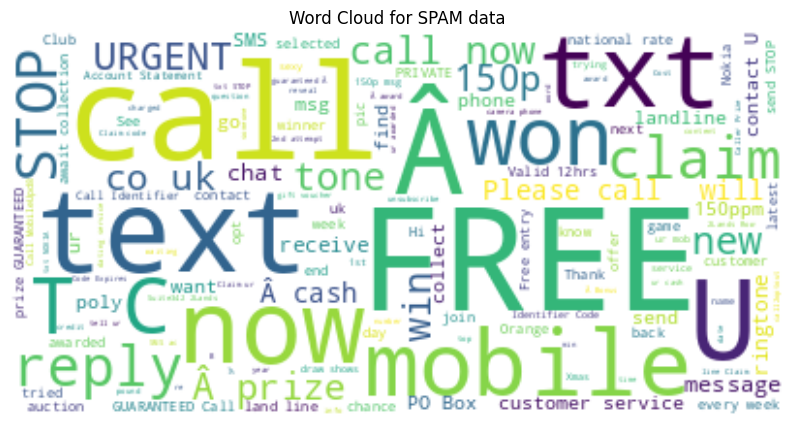

In [111]:
text_data_spam = ' '.join(spam_data.select('text').rdd.flatMap(lambda x: x).collect())
wordcloud = WordCloud(background_color='white').generate(text_data_spam)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for SPAM data')
plt.show()

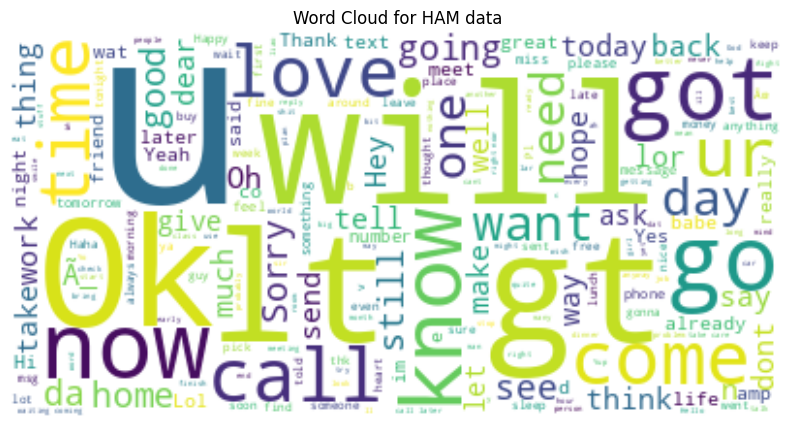

In [112]:
text_data_ham = ' '.join(ham_data.select('text').rdd.flatMap(lambda x: x).collect())
wordcloud = WordCloud(background_color='white').generate(text_data_ham)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for HAM data')
plt.show()

### numeric features using counvectorizer, this data is required for naive bayes

In [113]:
from pyspark.ml.feature import CountVectorizer

In [114]:
count_vectorizer = CountVectorizer(inputCol="Token_words", outputCol="count_vec")
vector_model=count_vectorizer.fit(final_data)

In [115]:
data_countVec=vector_model.transform(final_data)

In [116]:
data_countVec.show(4)

+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|class|                text|length|         Token_words|    after_remov_STOP|            word2vec|           count_vec|
+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|  ham|Go until jurong p...|   111|[go, until, juron...|[go, jurong, poin...|[0.00293911184962...|(13542,[8,42,51,6...|
|  ham|Ok lar... Joking ...|    29|[ok, lar..., joki...|[ok, lar..., joki...|[0.00327084316328...|(13542,[5,74,407,...|
| spam|Free entry in 2 a...|   155|[free, entry, in,...|[free, entry, 2, ...|[0.00791389956746...|(13542,[0,3,8,20,...|
|  ham|U dun say so earl...|    49|[u, dun, say, so,...|[u, dun, say, ear...|[0.00499346420272...|(13542,[5,22,60,1...|
+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+
only showing top 4 rows



### Finding frequencies of each word

In [117]:
from pyspark.sql.functions import count,explode

In [118]:
# Here the data generated from data having token words
data_exploded=data_filtered.withColumn("word",explode("Token_words"))
word_count=data_exploded.groupby("word").agg(count("*").alias("count"))
word_count.show(30)

+-----------------+-----+
|             word|count|
+-----------------+-----+
|             some|  118|
|            still|  150|
|              ...|  163|
|             hope|  102|
|            those|   27|
|      transaction|    4|
|              few|   42|
|              dnt|   13|
|        bookshelf|    1|
|             way!|    2|
|            spoil|    1|
|             t91.|    1|
|          6months|    3|
|           heart-|    1|
|       ah...gee..|    1|
|            1843.|    1|
|         low-cost|    1|
|            inner|    1|
|           travel|    3|
|         company?|    1|
|           online|   14|
|        arguments|    1|
|    videosounds+2|    1|
|            dick.|    1|
|(marriage)program|    1|
|         earth...|    1|
|               t.|    2|
|            89555|    2|
|         priority|    1|
|              art|    2|
+-----------------+-----+
only showing top 30 rows



### String Indexer

In [119]:
from pyspark.ml.feature import StringIndexer

In [120]:
ham_spam_to_num=StringIndexer(inputCol="class",outputCol="Label")
string_model=ham_spam_to_num.fit(data_countVec)

In [121]:
data_str_index=string_model.transform(data_countVec)
data_str_index.show(5)

+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+
|class|                text|length|         Token_words|    after_remov_STOP|            word2vec|           count_vec|Label|
+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+
|  ham|Go until jurong p...|   111|[go, until, juron...|[go, jurong, poin...|[0.00293911184962...|(13542,[8,42,51,6...|  0.0|
|  ham|Ok lar... Joking ...|    29|[ok, lar..., joki...|[ok, lar..., joki...|[0.00327084316328...|(13542,[5,74,407,...|  0.0|
| spam|Free entry in 2 a...|   155|[free, entry, in,...|[free, entry, 2, ...|[0.00791389956746...|(13542,[0,3,8,20,...|  1.0|
|  ham|U dun say so earl...|    49|[u, dun, say, so,...|[u, dun, say, ear...|[0.00499346420272...|(13542,[5,22,60,1...|  0.0|
|  ham|Nah I don't think...|    61|[nah, i, don't, t...|[nah, think, goes...|[0.00665557487601...|(13542,[0,1,66,89...

# Applying NaiveBayes

### Testing & Training data

In [122]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [123]:
Fdata=data_str_index

In [124]:
train_data, test_data= Fdata.randomSplit([0.7, 0.3])  # 70:30 ratio
naive_bayes = NaiveBayes(labelCol='Label', featuresCol='count_vec' )

#### Creating model...

In [125]:
ml_model=naive_bayes.fit(train_data)
predictions=ml_model.transform(test_data)
print(predictions)

DataFrame[class: string, text: string, length: int, Token_words: array<string>, after_remov_STOP: array<string>, word2vec: vector, count_vec: vector, Label: double, rawPrediction: vector, probability: vector, prediction: double]


In [126]:
predictions.show(5)

+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|class|                text|length|         Token_words|    after_remov_STOP|            word2vec|           count_vec|Label|       rawPrediction|         probability|prediction|
+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+----------+
|  ham|"7 wonders in My ...|   156|["7, wonders, in,...|["7, wonders, wor...|[0.01348325717621...|(13542,[2,6,8,9,2...|  0.0|[-242.05587369311...|[0.99999970414538...|       0.0|
|  ham|"7 wonders in My ...|   156|["7, wonders, in,...|["7, wonders, wor...|[0.01348325717621...|(13542,[2,6,8,9,2...|  0.0|[-242.05587369311...|[0.99999970414538...|       0.0|
|  ham|"A swt thought: \...|   161|["a, swt, thought...|["a, swt, thought...|[0.00559409954197...|(13542,

#### Metric results using classification..

In [127]:
evaluator=MulticlassClassificationEvaluator(labelCol="Label",predictionCol="prediction")

In [128]:
predictions.select("Label","class","prediction","probability").show(10)

+-----+-----+----------+--------------------+
|Label|class|prediction|         probability|
+-----+-----+----------+--------------------+
|  0.0|  ham|       0.0|[0.99999970414538...|
|  0.0|  ham|       0.0|[0.99999970414538...|
|  0.0|  ham|       0.0|[0.99999982805675...|
|  0.0|  ham|       0.0|[0.99999996470972...|
|  0.0|  ham|       0.0|[0.99999996193245...|
|  0.0|  ham|       0.0|[0.93322773058079...|
|  0.0|  ham|       0.0|[1.0,6.8958281052...|
|  0.0|  ham|       0.0|[1.0,6.8958281052...|
|  0.0|  ham|       0.0|[0.99997054551889...|
|  0.0|  ham|       0.0|[0.82177097588967...|
+-----+-----+----------+--------------------+
only showing top 10 rows



In [129]:
# Compute the confusion matrix
confusion_matrix_nb = predictions.groupby('label').pivot('prediction').count().na.fill(0)

# Display the confusion matrix
confusion_matrix_nb .show()

+-----+----+---+
|label| 0.0|1.0|
+-----+----+---+
|  0.0|1428| 24|
|  1.0|  19|221|
+-----+----+---+



Evaluation Metrics

In [130]:
accuracy_nb=evaluator.evaluate(predictions,{evaluator.metricName:"accuracy"})
precision_nb = evaluator.evaluate(predictions,{evaluator.metricName:"weightedPrecision"})
recall_nb = evaluator.evaluate(predictions,{evaluator.metricName:"weightedRecall"})
f1_nb = evaluator.evaluate(predictions,{evaluator.metricName:"f1"})
table= [("Accuracy", accuracy_nb*100), ("Precision", precision_nb*100), ("Recall", recall_nb*100), ("F1-Score", f1_nb*100)]
table_df = pd.DataFrame(table, columns=["Metric", "Value"])
table_df

,Metric,Value
0,Accuracy,97.458629
1,Precision,97.483696
2,Recall,97.458629
3,F1-Score,97.469537


# Apply SVM

In [131]:
from pyspark.ml.feature import HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline

In [132]:
svm_data=data_str_index

In [133]:
svm_data.printSchema()

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- Token_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- after_remov_STOP: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- word2vec: vector (nullable = true)
 |-- count_vec: vector (nullable = true)
 |-- Label: double (nullable = false)



In [134]:
# Apply feature extraction using HashingTF and IDF
hashing_tf = HashingTF(inputCol="Token_words", outputCol="features")


In [135]:
idf = IDF(inputCol="features", outputCol="tf_idf_features")

In [136]:
# Create a pipeline to chain the feature extraction steps
pipeline = Pipeline(stages=[hashing_tf, idf])

In [137]:
# Fit and transform the data
transformed_data = pipeline.fit(svm_data).transform(svm_data)
transformed_data.show(5)

+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+
|class|                text|length|         Token_words|    after_remov_STOP|            word2vec|           count_vec|Label|            features|     tf_idf_features|
+-----+--------------------+------+--------------------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+
|  ham|Go until jurong p...|   111|[go, until, juron...|[go, jurong, poin...|[0.00293911184962...|(13542,[8,42,51,6...|  0.0|(262144,[38555,52...|(262144,[38555,52...|
|  ham|Ok lar... Joking ...|    29|[ok, lar..., joki...|[ok, lar..., joki...|[0.00327084316328...|(13542,[5,74,407,...|  0.0|(262144,[51783,15...|(262144,[51783,15...|
| spam|Free entry in 2 a...|   155|[free, entry, in,...|[free, entry, 2, ...|[0.00791389956746...|(13542,[0,3,8,20,...|  1.0|(262144,[9443,122...|(262144,[9443,

In [138]:
train_data, test_data = transformed_data.randomSplit([0.7, 0.3], seed=42)

In [139]:
svm = LinearSVC(labelCol="Label", featuresCol="tf_idf_features")
svm_model = svm.fit(train_data)


In [140]:
svm_predictions = svm_model.transform(test_data)


In [141]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

In [142]:
# Compute the confusion matrix
confusion_matrix_svm = svm_predictions.groupby('Label').pivot('prediction').count().na.fill(0)

# Display the confusion matrix
confusion_matrix_svm.show()

+-----+----+---+
|Label| 0.0|1.0|
+-----+----+---+
|  0.0|1360| 20|
|  1.0|  15|198|
+-----+----+---+



In [143]:
accuracy_svm=evaluator.evaluate(svm_predictions,{evaluator.metricName:"accuracy"})
precision_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"weightedPrecision"})
recall_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"weightedRecall"})
f1_svm = evaluator.evaluate(svm_predictions,{evaluator.metricName:"f1"})
table_svm= [("Accuracy", accuracy_svm*100), ("Precision", precision_svm*100), ("Recall", recall_svm*100), ("F1-Score", f1_svm*100)]
table_df_svm = pd.DataFrame(table_svm, columns=["Metric", "Value"])
table_df_svm

,Metric,Value
0,Accuracy,97.802888
1,Precision,97.828259
2,Recall,97.802888
3,F1-Score,97.813638


# Applying decision tree classifier

In [144]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler

In [145]:
tree_data=data_str_index

In [146]:
tree_data.printSchema()

root
 |-- class: string (nullable = true)
 |-- text: string (nullable = true)
 |-- length: integer (nullable = true)
 |-- Token_words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- after_remov_STOP: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- word2vec: vector (nullable = true)
 |-- count_vec: vector (nullable = true)
 |-- Label: double (nullable = false)



### preparing a feature vector

In [147]:
assembler = VectorAssembler(inputCols=["length","word2vec","count_vec"], outputCol="features")

In [148]:
tree_data=assembler.transform(tree_data)

In [149]:
trainData, testData = tree_data.randomSplit([0.7, 0.3], seed=42)

### training using decision tree classifier

In [150]:
tree= DecisionTreeClassifier(labelCol="Label", featuresCol="features")
tree_model = tree.fit(trainData)

### make predictions on test data

In [151]:

tree_predictions = tree_model.transform(testData)


### model's performance

In [152]:
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

In [153]:
# Compute the confusion matrix
confusion_matrix_tree = tree_predictions.groupby('Label').pivot('prediction').count().na.fill(0)

# Display the confusion matrix
confusion_matrix_tree.show()

+-----+----+---+
|Label| 0.0|1.0|
+-----+----+---+
|  0.0|1371|  9|
|  1.0|  62|151|
+-----+----+---+



In [154]:

accuracy_tree=evaluator.evaluate(tree_predictions,{evaluator.metricName:"accuracy"})
precision_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"weightedPrecision"})
recall_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"weightedRecall"})
f1_tree = evaluator.evaluate(tree_predictions,{evaluator.metricName:"f1"})
table_tree= [("Accuracy", accuracy_tree*100), ("Precision", precision_tree*100), ("Recall", recall_tree*100), ("F1-Score", f1_tree*100)]
table_df_tree = pd.DataFrame(table_tree, columns=["Metric", "Value"])
table_df_tree

,Metric,Value
0,Accuracy,95.543001
1,Precision,95.499802
2,Recall,95.543001
3,F1-Score,95.268338


# Applying random forest

In [155]:

from pyspark.ml.classification import RandomForestClassifier


In [156]:
trainData, testData = tree_data.randomSplit([0.7, 0.3], seed=42)


In [157]:
rf = RandomForestClassifier(labelCol="Label", featuresCol="features")
rf_model = rf.fit(trainData)

In [158]:
rf_predictions = rf_model.transform(testData)

In [159]:
# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="Label", predictionCol="prediction")

In [160]:
confusion_matrix_rf = rf_predictions.groupby('Label').pivot('prediction').count().na.fill(0)
confusion_matrix_rf.show()

+-----+----+---+
|Label| 0.0|1.0|
+-----+----+---+
|  0.0|1380|  0|
|  1.0| 194| 19|
+-----+----+---+



In [161]:
accuracy_rf=evaluator.evaluate(rf_predictions,{evaluator.metricName:"accuracy"})
precision_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"weightedPrecision"})
recall_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"weightedRecall"})
f1_rf = evaluator.evaluate(rf_predictions,{evaluator.metricName:"f1"})
table_rf= [("Accuracy", accuracy_rf*100), ("Precision", precision_rf*100), ("Recall", recall_rf*100), ("F1-Score", f1_rf*100)]
table_df_rf = pd.DataFrame(table_rf, columns=["Metric", "Value"])
table_df_rf

,Metric,Value
0,Accuracy,87.821720
1,Precision,89.322728
2,Recall,87.821720
3,F1-Score,83.129835


**Comparision of Classifiers**

In [162]:
import matplotlib.pyplot as plt

In [163]:
classifiers = ['Naive Bayes','SVM','Decision Tree' ,'Random Forest']

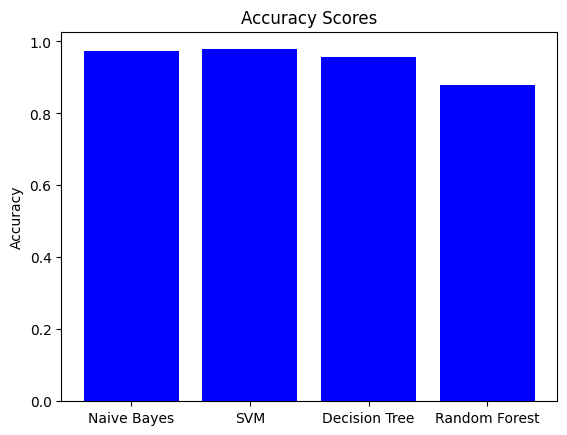

In [164]:
accuracy_scores = [accuracy_nb,accuracy_svm,accuracy_tree,accuracy_rf]
plt.bar( classifiers,accuracy_scores , color='blue')
plt.title('Accuracy Scores')
plt.ylabel('Accuracy')
plt.show()

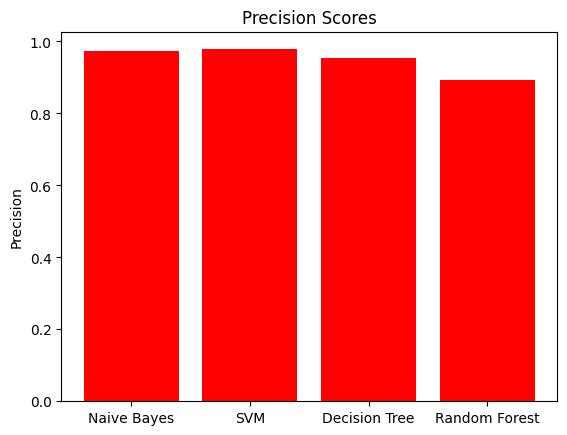

In [165]:
Precision_scores =[precision_nb,precision_svm,precision_tree,precision_rf]
plt.bar( classifiers,Precision_scores , color='red')
plt.title('Precision Scores')
plt.ylabel('Precision')
plt.show()

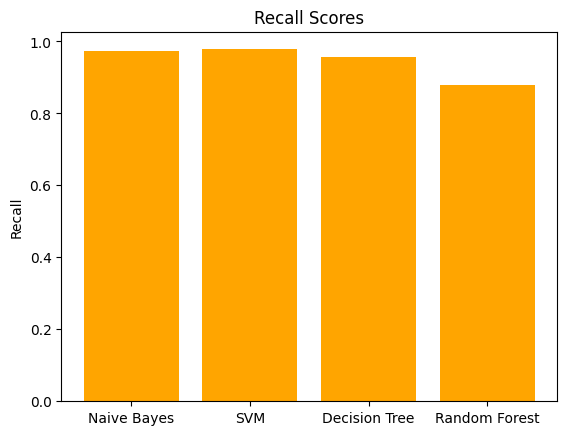

In [166]:
Recall_scores = [recall_nb,recall_svm,recall_tree,recall_rf]
plt.bar( classifiers,Recall_scores , color='orange')
plt.title('Recall Scores')
plt.ylabel('Recall')
plt.show()

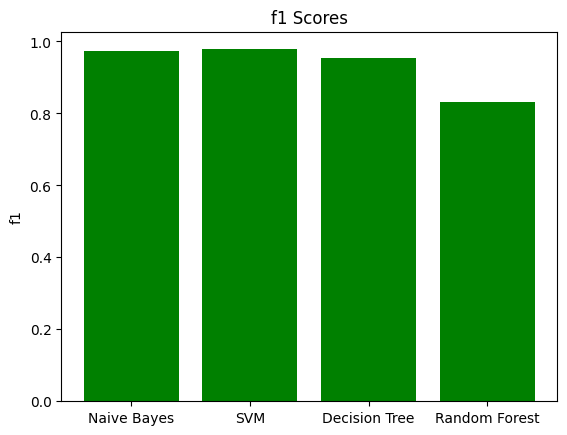

In [167]:
f1_scores = [f1_nb,f1_svm,f1_tree,f1_rf]
plt.bar( classifiers,f1_scores , color='green')
plt.title('f1 Scores')
plt.ylabel('f1')
plt.show()